# Load Libraries

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import re
import requests,io

from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.table import Table
from scipy import interpolate
from shapely.geometry import LineString, Point
from astropy.stats import sigma_clipped_stats

from astropy.io import fits
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm, SigmaClip
from astropy.table import QTable
from astropy.utils.exceptions import AstropyDeprecationWarning


from photutils.background import LocalBackground, MMMBackground,Background2D,MedianBackground
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry, IntegratedGaussianPRF,prepare_psf_model, IterativelySubtractedPSFPhotometry, DAOGroup, SourceGrouper

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load the reduced data

In [54]:
data_path = 'wednesday'

In [55]:
data = {}
data["M71B"] = np.load(f'{data_path}/M71B.npy')
data["M71V"] = np.load(f'{data_path}/M71G.npy')

In [56]:
for key, image in data.items():
    print(image.shape)

(1024, 1536)
(1024, 1536)


In [57]:
error = {}
error["M71B"] = np.load(f'{data_path}/M71B_error.npy')
error["M71V"] = np.load(f'{data_path}/M71G_error.npy')[0]

# Background Estimation


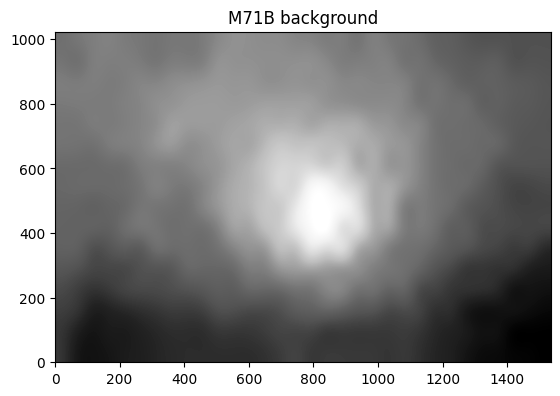

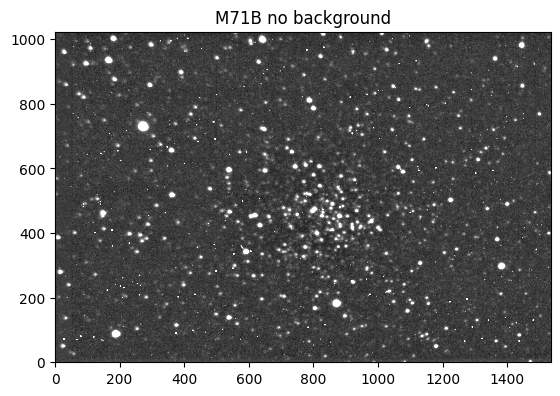

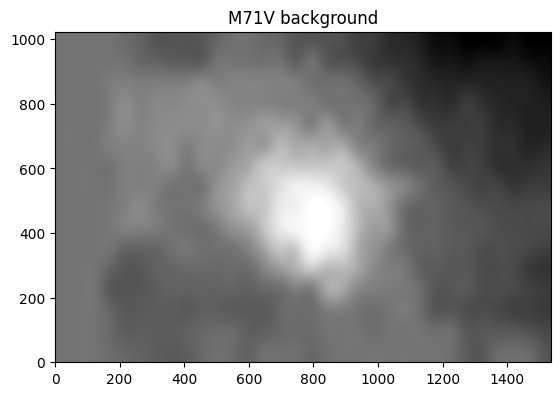

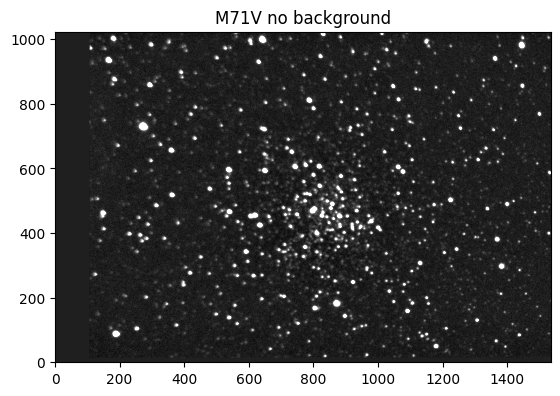

In [58]:
bkgs={}
bkg_uncs = {}
for key, image in data.items():
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image,
                       (64,48), #they say it works better if data is covered by int nb of boxes
                       filter_size=(3,3),sigma_clip=sigma_clip,
                    bkg_estimator=bkg_estimator)
    bkgs[key] = bkg.background
    bkg_uncs[key] = bkg.background_rms
    plt.title(f'{key} background')
    plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
    plt.show()

    lo,up= np.percentile(image-bkg.background,1),np.percentile(image-bkg.background,99)
    plt.imshow(image-bkg.background, cmap='gray', origin='lower', clim=(lo,up))
    plt.title(f'{key} no background')
    plt.show()

    data[key] = image - bkg.background




# Get 2D FWHM

Found 389 stars in image M71B


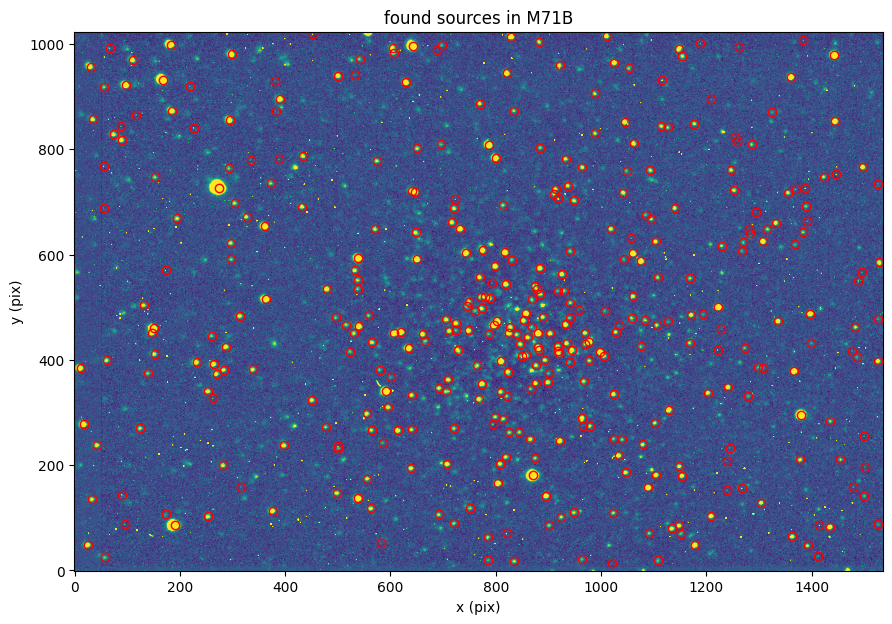

     x-FWHM 7.520484027309241+/-0.4995360319368272 (pix) for this M71B 
     y-FWHM 7.543236709437705+/-0.5430323491753691 (pix) for this M71B 
     FWHM 8.276898284693187+/-0.43044286096194867 (pix) for this M71B 
Found 692 stars in image M71V


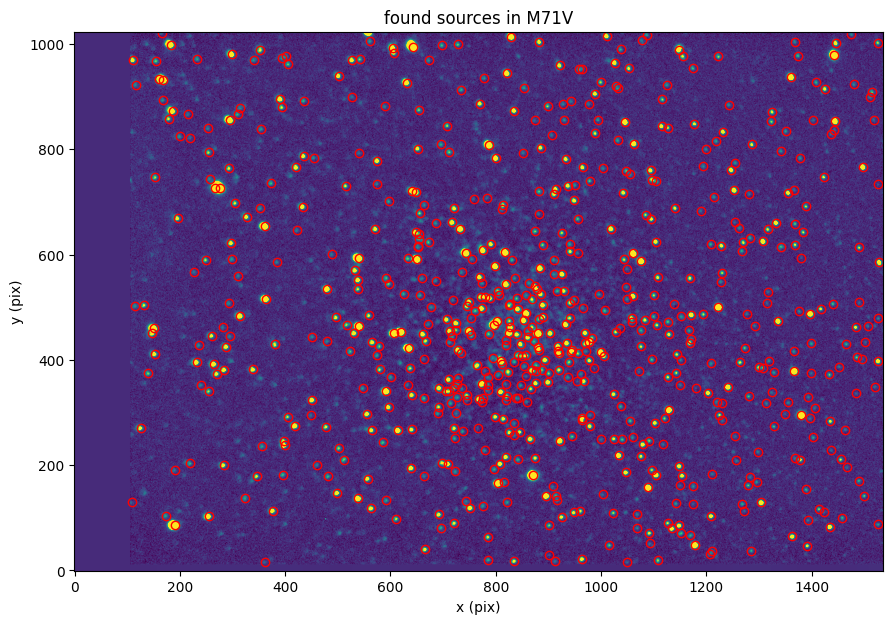

     x-FWHM 6.8283668985039725+/-0.4662818435820935 (pix) for this M71V 
     y-FWHM 6.7612038905394565+/-0.5070008354796839 (pix) for this M71V 
     FWHM 6.50358785502348+/-0.44311147045333255 (pix) for this M71V 


In [59]:
xfwhms = {}
yfwhms = {}
fwhms = {}
for key, image in data.items():
    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=50)
    ## Find stars
    daofind = DAOStarFinder(fwhm=5.5, threshold=6.0*std, exclude_border= True)
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars 
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1][0:nbright]
    brsources = sources[brightest]

    ##########
    #get fwhm
    rmax = 25
    (ny,nx) = np.shape(image)
    from astropy.modeling import models,fitting
    fit_g = fitting.LevMarLSQFitter()
    allxfwhm, allyfwhm = np.zeros(len(brsources)),np.zeros(len(brsources))
    allfwhm,alltheta = np.zeros(len(brsources)),np.zeros(len(brsources))
    for i,src in enumerate(brsources):
        if int(src['ycentroid']) > rmax and int(src['ycentroid']) < ny-rmax and \
            int(src['xcentroid']) > rmax and int(src['xcentroid']) < nx-rmax:
            img = image[int(src['ycentroid'])-rmax:int(src['ycentroid'])+rmax,
                        int(src['xcentroid'])-rmax:int(src['xcentroid'])+rmax]
            subx,suby = np.indices(img.shape) # instead of meshgrid
            p_init = models.Gaussian2D(amplitude=np.max(img),x_mean=rmax,y_mean=rmax,x_stddev=1.0,y_stddev=1.0)
            fitgauss = fit_g(p_init, subx, suby, img - np.min(img))
            allxfwhm[i] = np.abs(fitgauss.x_stddev.value)
            allyfwhm[i] = np.abs(fitgauss.y_stddev.value)
            allfwhm[i] = 0.5*(allxfwhm[i]+allyfwhm[i])
            alltheta[i] = fitgauss.theta.value
    xfwhm,yfwhm = np.median(allxfwhm)*gaussian_sigma_to_fwhm,np.median(allyfwhm)*gaussian_sigma_to_fwhm
    fwhm = np.median(allfwhm)*gaussian_sigma_to_fwhm
    sigfwhm, sigxfwhm, sigyfwhm = np.std(allfwhm), np.std(allxfwhm), np.std(allyfwhm)
    medtheta = np.median(alltheta)
    print(f"     x-FWHM {xfwhm}+/-{sigxfwhm} (pix) for this {key} ")
    print(f"     y-FWHM {yfwhm}+/-{sigyfwhm} (pix) for this {key} ")
    print(f"     FWHM {fwhm}+/-{sigfwhm} (pix) for this {key} ")

    fwhms[key] = fwhm
    xfwhms[key] = xfwhm
    yfwhms[key] = yfwhm


# 2d gaussians

In [60]:
twodgauss = {}
psf_models = {}
for key, image in data.items():
    twodgauss[key] =  models.Gaussian2D(x_stddev=xfwhms[key]/gaussian_sigma_to_fwhm,
                                        y_stddev=yfwhms[key]/gaussian_sigma_to_fwhm,
                                        )
    
    #twodgauss[key].xname = 'x'
    #twodgauss[key].yname = 'y'
    #twodgauss[key].fluxname = 'amplitude'

    psf_models[key] = prepare_psf_model(twodgauss[key],xname='x_mean',yname='y_mean',fluxname='amplitude')


    

# Find point sources more accuretly with FWHM
more stars found this way:)

In [61]:
fwhms

{'M71B': 8.276898284693187, 'M71V': 6.50358785502348}

Found 549 stars in image M71B


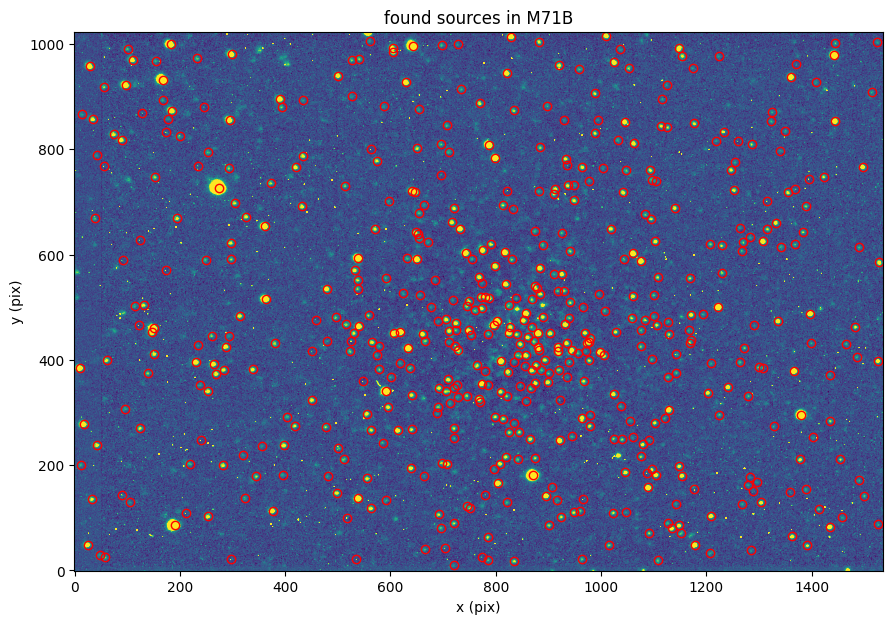

Found 889 stars in image M71V


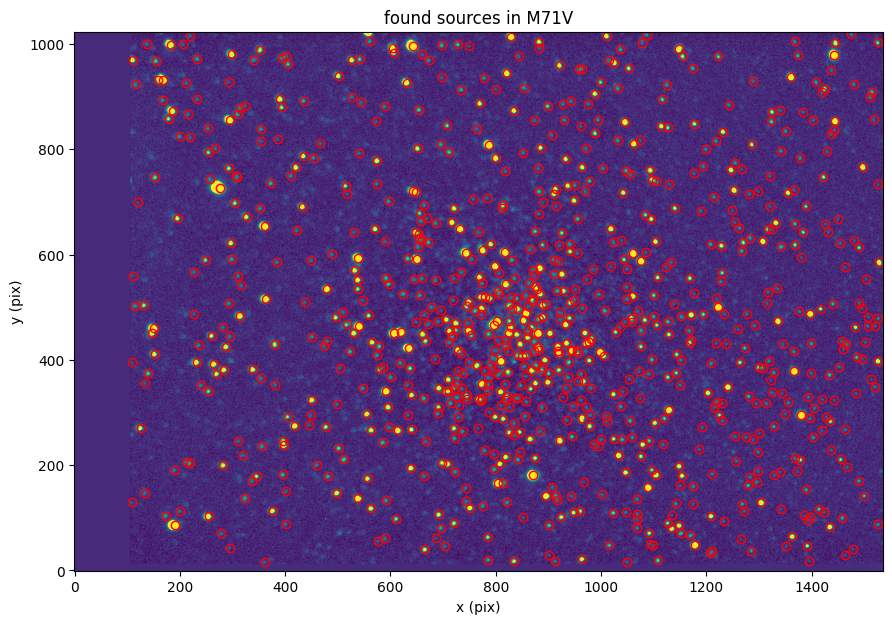

In [62]:
x_inits = {}
y_inits = {}

daofinds = {}

for key, image in data.items():

    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=50)
    ## Find stars
    daofind = DAOStarFinder(fwhm=fwhms[key], threshold=6.0*std, exclude_border= True)
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    daofinds[key]=daofind

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars and save
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1]#[0:nbright]
    brsources = sources[brightest]

    x_inits[key] = brsources['xcentroid']
    y_inits[key] = brsources['ycentroid']



# Iterative PSF Photometry :)

In [63]:
phots = {}

for key, image in data.items():

    group = SourceGrouper(fwhms[key])
    PSF = PSFPhotometry(
        grouper=group ,     
        psf_model=IntegratedGaussianPRF(sigma=fwhms[key]/gaussian_sigma_to_fwhm),
        finder=daofinds[key],
        fit_shape=(3,3), #play with this, this may be small
        aperture_radius=5 ,#play with this as well
        fitter_maxiters=500
    )
    init_params = QTable()
    init_params['x'] = x_inits[key]
    init_params['y'] = y_inits[key]

    phots[key] = PSF(image, 
                        init_params = init_params,
                        error=np.sqrt(np.square(bkg_uncs[key])+np.square(error[key])), 
                )

In [64]:
phots['M71B']

<QTable length=549>
  id  group_id local_bkg ...           cfit          flags
int32  int32    float64  ...         float64         int32
----- -------- --------- ... ----------------------- -----
    1        1       0.0 ...  1.0490057024165468e-07     0
    2        2       0.0 ...   7.755271643294509e-07     0
    3        3       0.0 ...  1.8835034981526091e-06     0
    4        4       0.0 ...   4.970907244453545e-07     0
    5        5       0.0 ...  1.8868389308891841e-06     0
    6        6       0.0 ...   3.493846260239829e-06     0
    7        7       0.0 ...   7.093784518728431e-07     0
    8        8       0.0 ...   5.494640440952009e-06     0
    9        9       0.0 ...  1.4225389799039821e-05     0
   10       10       0.0 ...  3.1733938647008733e-06     0
  ...      ...       ... ...                     ...   ...
  540      528       0.0 ...   0.0023535319169077098     0
  541      529       0.0 ...   0.0009733668336990444     0
  542      530       0.0 ...  5.3663162336882534e-05     0
  543      531       0.0 ...  0.00019583912032203668     0
  544      532       0.0 ... -0.00020542923403489197     0
  545      533       0.0 ...   0.0005101115026093373     0
  546      534       0.0 ...  5.9475604143717294e-05     0
  547      535       0.0 ...   0.0001915471622475711     0
  548      536       0.0 ... -0.00015362156123324133     0
  549      537       0.0 ...  4.6055438384567573e-07     0

## See found stars 

<Figure size 640x480 with 0 Axes>

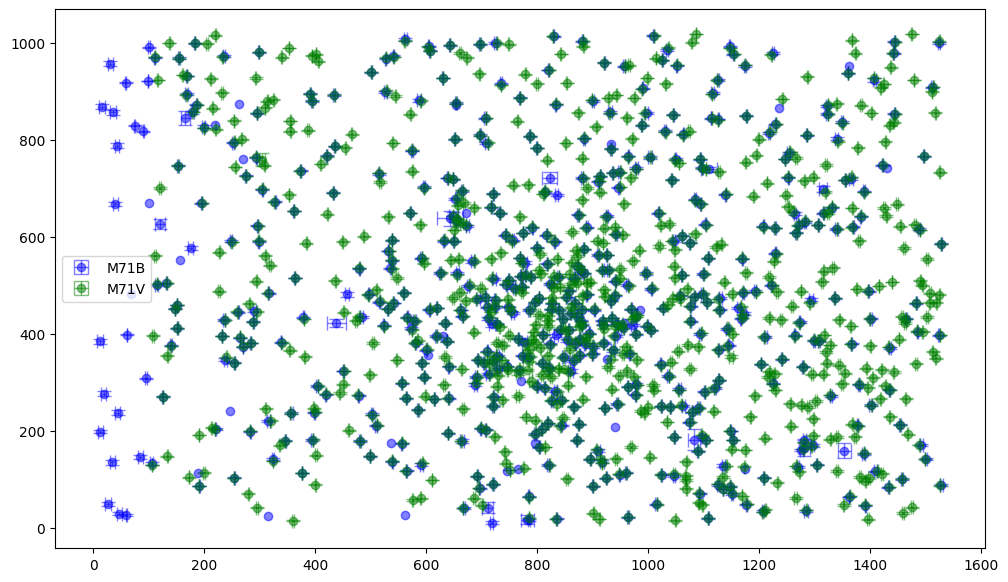

In [65]:

plt.clf()
fig = plt.figure(figsize=(12,7))
#plt.scatter(phots['M71B']['x_fit'],phots['M71B']['y_fit'], marker='o', c='blue', alpha=0.5)
#plt.scatter(phots['M71V']['x_fit'],phots['M71V']['y_fit'], marker='o', c='green',alpha=0.5)

plt.errorbar(x=phots['M71B']['x_fit'],y=phots['M71B']['y_fit'],
             xerr=phots['M71B']['x_err'],
             yerr=phots['M71B']['y_err'],fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue',label="M71B",alpha=0.5
              )
plt.errorbar(x=phots['M71V']['x_fit'],y=phots['M71V']['y_fit'],
             xerr=phots['M71V']['x_err'],
             yerr=phots['M71V']['y_err'],fmt='o', ecolor='green', elinewidth=1, capsize=5,c='green',label="M71V",alpha=0.5
              )
plt.legend()

plt.show()

## Create dataframe for both Filters

In [66]:
m71b = phots['M71B'].to_pandas()
m71v = phots['M71V'].to_pandas()


In [67]:
# function to filter out some bad points

def clean_df(data, n=0):
    # Drop rows with missing values
    df = data.dropna(inplace=False)

    # Apply the initial filtering conditions
    cond = (df['flags'] == 0) & (df['x_fit'] > 0) & (df['x_fit'] < 1536) & (df['y_fit'] > 0) & (df['y_fit'] < 1024)
    filtered_df = df[cond].copy()

    # Keep only nth lines with the highest 'flux_fit'
    if n > 0:
        filtered_df = filtered_df.nlargest(n, 'flux_fit')

    return filtered_df




In [68]:
print(f"B : {m71b.shape}")
print(f"V : {m71v.shape}")


B : (549, 17)
V : (889, 17)


In [69]:
m71b = clean_df(m71b)
m71v = clean_df(m71v)



In [70]:
print(f"B : {m71b.shape}")
print(f"V : {m71v.shape}")

B : (517, 17)
V : (889, 17)


In [71]:
matched_indexes_b = []
matched_indexes_v = []

margin = 1 #3 pixeis

dfs_to_concat = []

m71 = pd.DataFrame(columns = ["Bflux", "Vflux","Bflux_inc",'Vflux_inc', "Bx", "Bx_err", "By", "By_err", "Vx", "Vx_err", "Vy", "Vy_err" ])
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for i_m71v, row_m71v in m71v.iterrows():
        for i_m71b, row_m71b in m71b.iterrows():
            if abs(row_m71v['x_fit'] - row_m71b['x_fit']) < margin and abs(row_m71b['y_fit'] - row_m71v['y_fit']) < margin:
                df_to_append = pd.DataFrame({
                'Bflux': [row_m71b['flux_fit']],
                'Vflux': [row_m71v['flux_fit']],
                'Bflux_inc': [row_m71b['flux_err']],
                'Vflux_inc': [row_m71v['flux_err']],
                'Bx': [row_m71b['x_fit']],
                'Bx_err': [row_m71b['x_err']],
                'By': [row_m71b['y_fit']],
                'By_err': [row_m71b['y_err']],
                'Vx': [row_m71v['x_fit']],
                'Vx_err': [row_m71v['x_err']],
                'Vy': [row_m71v['y_fit']],
                'Vy_err': [row_m71v['y_err']],
                

            })
                dfs_to_concat.append(df_to_append)

                if (i_m71v in matched_indexes_v) or (i_m71b in matched_indexes_b):
                    print(f"Something's wrong {i_m71v} {i_m71b}")
                matched_indexes_b.append(i_m71b)
                matched_indexes_v.append(i_m71v)


m71 = pd.concat(dfs_to_concat, ignore_index=True)

#m71b['flux_fit']
print(m71["Bflux"])



0      683483.161327
1      352333.137986
2       66442.637587
3      110107.057344
4      206147.588454
           ...      
221      1330.506989
222      1737.872055
223      1548.943672
224      1884.292654
225      1238.278895
Name: Bflux, Length: 226, dtype: float64


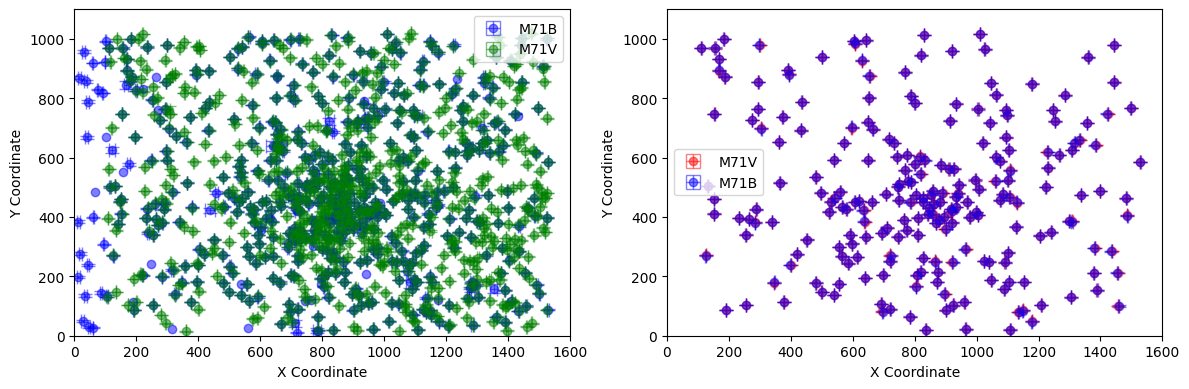

In [72]:
#SEE THE DIFFERENCE OF CORRESPOND STARS

plt.figure(figsize=(12, 4))  

plt.subplot(1, 2, 1) 
plt.errorbar(x=phots['M71B']['x_fit'],y=phots['M71B']['y_fit'],
             xerr=phots['M71B']['x_err'],
             yerr=phots['M71B']['y_err'],fmt='o', elinewidth=1, capsize=5,c='blue',label="M71B",alpha=0.5
              )
plt.errorbar(x=phots['M71V']['x_fit'],y=phots['M71V']['y_fit'],
             xerr=phots['M71V']['x_err'],
             yerr=phots['M71V']['y_err'],fmt='o', elinewidth=1, capsize=5,c='green',label="M71V",alpha=0.5
              )

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 1600)  
plt.ylim(0, 1100) 
plt.legend()

plt.subplot(1, 2, 2)  

plt.errorbar(x=m71["Vx"],y=m71["Vy"],
             xerr=m71["Vx_err"],
             yerr=m71["Vy_err"],fmt='o', elinewidth=1, capsize=5,c='red',label="M71V",alpha=0.5
              )

plt.errorbar(x=m71["Bx"],y=m71["By"],
             xerr=m71["Bx_err"],
             yerr=m71["By_err"],fmt='o', elinewidth=1, capsize=5,c='blue',label="M71B",alpha=0.5
              )



plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 1600)  
plt.ylim(0, 1100) 
plt.legend()


plt.tight_layout()
plt.show()





-17.682160425341095
-18.506631818655492
226
150


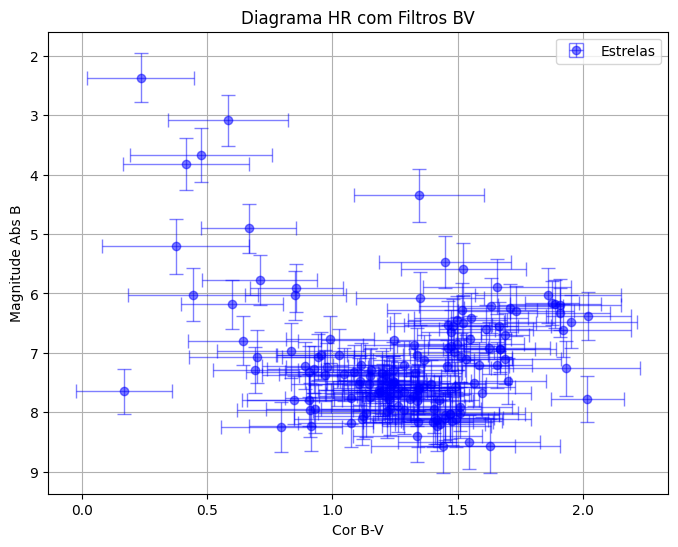

In [73]:
m71_Bflux = m71["Bflux"]/90
m71_Vflux = m71["Vflux"]/60

m71_Bflux_inc =m71["Bflux_inc"]/90
m71_Vflux_inc =m71["Vflux_inc"]/60



#Standard star hip100108
#https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2020yCat.1350....0G
d_StStar=  59.791
d_StStar_err=0.1312 
M_abs_StStar_B_true = 5.64
M_abs_StStar_V_true = 5.58

StStar_Bflux = 330820.5932283057
StStar_Bflux_err= 26027.889649890487

M_abs_StStar_B = -2.5 * np.log10(abs(StStar_Bflux))
M_abs_StStar_B_err = abs(-2.5/StStar_Bflux)*StStar_Bflux_err

M_abs_StStar_B = M_abs_StStar_B - 5*np.log10(d_StStar) +5
M_abs_StStar_B_err = np.sqrt(M_abs_StStar_B_err**2+((-5/d_StStar)*d_StStar_err)**2)

print(M_abs_StStar_B)

StStar_Vflux = 706937.6199424627
StStar_Vflux_err = 54329.532996867296

M_abs_StStar_V = -2.5 * np.log10(abs(StStar_Vflux))
M_abs_StStar_V_err = abs(-2.5/StStar_Vflux)*StStar_Vflux_err

M_abs_StStar_V = M_abs_StStar_V - 5*np.log10(d_StStar) +5
M_abs_StStar_V_err = np.sqrt(M_abs_StStar_V_err**2+((-5/d_StStar)*d_StStar_err)**2)

print(M_abs_StStar_V)

diff_magn_StStar = M_abs_StStar_B - M_abs_StStar_V

#https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2021MNRAS.504..356D
d= 1785
d_err=107

#magnitudes aparentes
m_app=[]
m_app_err=[]

m_app.append(-2.5 * np.log10(abs(m71_Bflux)))
m_app.append(-2.5 * np.log10(abs(m71_Vflux)))
m_app=np.array(m_app)
#0-B
#1-V

m_app_err.append(abs(-2.5/m71_Bflux)*m71_Bflux_inc)
m_app_err.append(abs(-2.5/m71_Vflux)*m71_Vflux_inc)
m_app_err=np.array(m_app_err)

#diff magnitudes aparentes
color_indexBV=m_app[0]-m_app[1]
color_indexBV_err= np.sqrt(m_app_err[0]**2+m_app_err[1]**2)

M_abs=m_app - 5 * np.log10(d) + 5
M_abs_err=np.sqrt(m_app_err**2 + ((-5/d)*d_err)**2)

M_abs_calib ={}
M_abs_calib_err = {}
M_abs_calib[0]=M_abs[0] - (M_abs_StStar_B- M_abs_StStar_B_true)
M_abs_calib_err[0]=np.sqrt(M_abs_err[0]**2 + M_abs_StStar_B_err**2)

M_abs_calib[1]=M_abs[1] - (M_abs_StStar_V- M_abs_StStar_V_true)
M_abs_calib_err[1]=np.sqrt(M_abs_err[1]**2 + M_abs_StStar_V_err**2)

#color_indexBV= M_abs_calib[0]-M_abs_calib[1]
#color_indexBV_err= np.sqrt(M_abs_calib_err[0]**2+M_abs_calib_err[1]**2)

# Filter the data
filtered_color_indexBV = []
filtered_color_indexBV_err = []
filtered_M_abs_calib=[]
filtered_M_abs_calib_err=[]

i=0
for var, error in zip(color_indexBV, color_indexBV_err):
    if error < 0.3:
        filtered_color_indexBV.append(var)
        filtered_color_indexBV_err.append(error)
        filtered_M_abs_calib.append(M_abs_calib[0][i])
        filtered_M_abs_calib_err.append(M_abs_calib_err[0][i])
    i+=1

print(color_indexBV.size)
print(len(filtered_color_indexBV))

plt.figure(figsize=(8, 6))

plt.errorbar(x=filtered_color_indexBV,y=filtered_M_abs_calib,
             xerr=filtered_color_indexBV_err,
             yerr=filtered_M_abs_calib_err,fmt='o', elinewidth=1, capsize=5,c='blue',label="Estrelas",alpha=0.5
              )
plt.xlabel('Cor B-V')
#plt.ylim(15,-2)
plt.ylabel('Magnitude Abs B')
plt.title('Diagrama HR com Filtros BV')
plt.grid(True)

#inverter o eixo y, magnitude aumenta à medida que se vai para baixo no diagrama
plt.gca().invert_yaxis()

plt.legend()
plt.show()


In [74]:
#Read the models
#Important: Open the model file (in any text editor) and remove the # at the beginning of the line 13 (names of the columns)
#Otherwise python won't know the column names and will call them col1, col2 etc.
isochrones = Table.read('output993364478302.dat', format='ascii')
print(isochrones.columns)

#Let's see which ages we have in the model file
logages=np.unique(isochrones['logAge']) #find the unique age entries
ages=np.unique(10**isochrones['logAge']/1e6) #in Myrs
for logage, age in zip(logages,ages): print(logage,age) #print all of that

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Umag','Bmag','Vmag','Rmag','Imag','Jmag','Hmag','Kmag')>
7.0 10.0
7.09691 12.499999625598054
7.17609 14.999956513820402
7.24304 17.50007862882901
7.30103 20.000000199681043
7.35218 22.499869541650266
7.39794 24.9999995007974
7.43933 27.499829424260362
7.47712 29.999913327161497
7.51188 32.49974848542795
7.54407 35.00015760710141
7.57403 37.4998905357492
7.60206 40.00000079872417
7.62839 42.50010470526256
7.65321 44.99973953258027
7.67669 47.499605206891204
7.69897 49.9999995007974
7.72016 52.50008420833815
7.74036 54.99965939764019
7.75967 57.500285360875914
7.77815 59.999827253364394
7.79588 62.49999750398704
7.81291 64.99949761981426
7.8293 67.4994136121949
7.8451 70.00031591308975
7.86034 72.50033277865747
7.87506 74.99978182030029
7.8893 77.49969618775764
7.90309 80.00000239617252


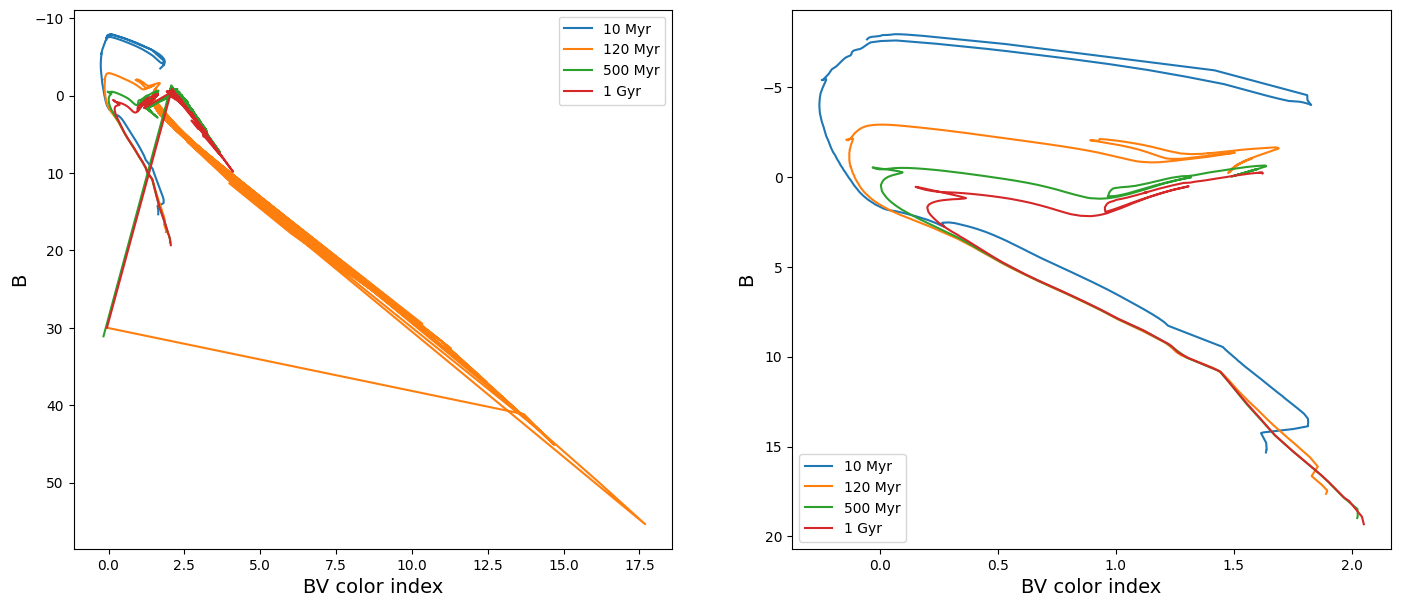

In [75]:
#you can select the isochrone with some particular age
age_1 = isochrones['logAge'] == 7 # 10 Myrs; False where not this age, True where yes
age_2 = isochrones['logAge'] == 8.07918 # 120 Myrs
age_3 = isochrones['logAge'] == 8.69897 # 500 Myrs
age_4 = isochrones['logAge'] == 9 # 1 Gyrs

fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(17,7))
ax1.plot(isochrones['Bmag'][age_1] - isochrones['Vmag'][age_1], isochrones['Bmag'][age_1],label='10 Myr')
ax1.plot(isochrones['Bmag'][age_2] - isochrones['Vmag'][age_2], isochrones['Bmag'][age_2],label='120 Myr')
ax1.plot(isochrones['Bmag'][age_3] - isochrones['Vmag'][age_3], isochrones['Bmag'][age_3],label='500 Myr')
ax1.plot(isochrones['Bmag'][age_4] - isochrones['Vmag'][age_4], isochrones['Bmag'][age_4],label='1 Gyr')
ax1.invert_yaxis()
ax1.set_xlabel('BV color index',fontsize=14)
ax1.set_ylabel('B',fontsize=14)
ax1.legend()

#We can cut off the more evolved stages
N=250
ax2.plot(isochrones['Bmag'][age_1][0:N] - isochrones['Vmag'][age_1][0:N], isochrones['Bmag'][age_1][0:N],label='10 Myr')
ax2.plot(isochrones['Bmag'][age_2][0:N] - isochrones['Vmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N],label='120 Myr')
ax2.plot(isochrones['Bmag'][age_3][0:N] - isochrones['Vmag'][age_3][0:N], isochrones['Bmag'][age_3][0:N],label='500 Myr')
ax2.plot(isochrones['Bmag'][age_4][0:N] - isochrones['Vmag'][age_4][0:N], isochrones['Bmag'][age_4][0:N],label='1 Gyr')
ax2.invert_yaxis()
ax2.set_xlabel('BV color index',fontsize=14)
ax2.set_ylabel('B',fontsize=14)
ax2.legend()

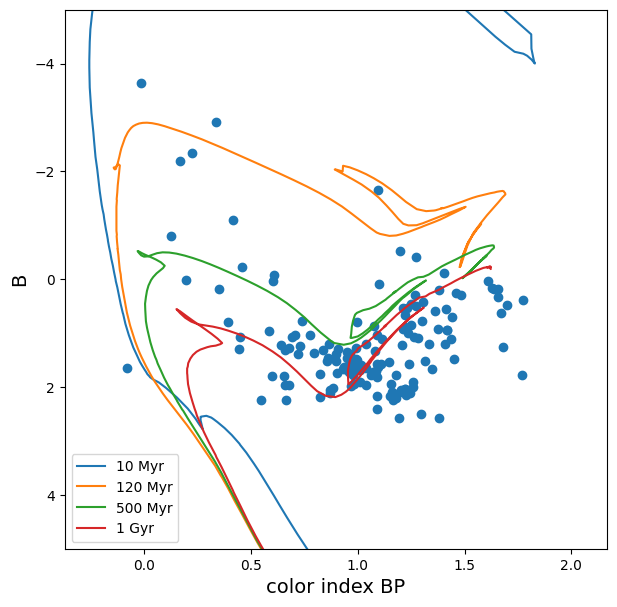

In [76]:
#Let's now plot a model on top of our data, just approximately
fig = plt.figure(figsize=(7,7))
plt.scatter(np.array(filtered_color_indexBV)-0.25,np.array(filtered_M_abs_calib)-6) # so tentei andar a procura do range que queremos mas a forma parece boa
plt.ylim(5,-5)
plt.xlabel('color index BP',fontsize=14)
plt.ylabel('B',fontsize=14)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
#median_parallax=np.nanmedian(data['parallax'])
#dist=1000/median_parallax #Important: This distance here is just for demonstration (approximate), we will use a different method o determine it
#DM=5*np.log10(dist)-5 #distance modulus
#print('distance modulus:',DM)
plt.plot(isochrones['Bmag'][age_1][0:N] - isochrones['Vmag'][age_1][0:N], isochrones['Bmag'][age_1][0:N],label='10 Myr')
plt.plot(isochrones['Bmag'][age_2][0:N] - isochrones['Vmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N],label='120 Myr')
plt.plot(isochrones['Bmag'][age_3][0:N] - isochrones['Vmag'][age_3][0:N], isochrones['Bmag'][age_3][0:N],label='500 Myr')
plt.plot(isochrones['Bmag'][age_4][0:N] - isochrones['Vmag'][age_4][0:N], isochrones['Bmag'][age_4][0:N],label='1 Gyr')
plt.legend()
#print(dist)